In [ ]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# --- CONFIGURATION: UPDATE THIS PATH ---
# Point this to where you uploaded the zip file in your Drive
ZIP_PATH = '/content/drive/MyDrive/Animals-10.zip'
# ---------------------------------------

# 2. Copy and Unzip to Local Colab Storage
if not os.path.exists('Animals-10'):
    print(f"Copying {ZIP_PATH} to local storage...")
    !cp "{ZIP_PATH}" animals-10.zip
    print("Unzipping...")
    !unzip -q animals-10.zip -d Animals-10
    print("Done.")

# 3. Find Images and Prepare Splits
DATA_DIR = 'Animals-10/raw-img'
if not os.path.exists(DATA_DIR):
    # Fallback to find the folder if the zip structure is different
    for root, dirs, files in os.walk('Animals-10'):
        if 'cane' in dirs:
            DATA_DIR = root
            break

class_names = sorted([d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))])
print(f"Classes found: {class_names}")

image_paths = []
labels = []
class_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATA_DIR, class_name)
    for f in os.listdir(class_dir):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, f))
            labels.append(class_to_index[class_name])

# Stratified Split (70% Train, 15% Val, 15% Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, labels, test_size=0.30, random_state=42, stratify=labels
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Class Weights
class_weights_arr = class_weight.compute_class_weight(
    class_weight='balanced', classes=np.unique(y_train), y=y_train
)
class_weights = {i: w for i, w in enumerate(class_weights_arr)}

print(f"Data ready: {len(X_train)} train, {len(X_val)} val, {len(X_test)} test.")

Mounted at /content/drive
Copying /content/drive/MyDrive/Animals-10.zip to local storage...
Unzipping...
Done.
Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Data ready: 18325 train, 3927 val, 3927 test.


In [ ]:
def process_image_baseline(image_path, label):
    # Load and Decode
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)

    # Resize to 224x224
    img = tf.image.resize(img, (224, 224))

    # Standard Rescaling for Custom CNNs (0 to 1)
    img = tf.cast(img, tf.float32) / 255.0

    return img, label

def build_dataset(paths, labels, is_training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image_baseline, num_parallel_calls=tf.data.AUTOTUNE)

    # Cache for speed
    ds = ds.cache()

    if is_training:
        ds = ds.shuffle(len(paths))
        # Simple Augmentation
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(64)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(X_train, y_train, is_training=True)
val_ds = build_dataset(X_val, y_val)
test_ds = build_dataset(X_test, y_test)
print("Baseline Pipeline Ready.")

Baseline Pipeline Ready.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def build_baseline_cnn(input_shape=(224, 224, 3), num_classes=10):
    model = Sequential([
        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 4
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Classification Head
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ], name="Baseline_CNN")

    return model

model = build_baseline_cnn()

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint('baseline_best.keras', save_best_only=True, monitor='val_loss')
early_stop = EarlyStopping(patience=5, restore_best_weights=True)

print("Starting Baseline CNN Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop]
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Starting Baseline CNN Training...
Epoch 1/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 103s 265ms/step - accuracy: 0.1893 - loss: 6.3811 - val_accuracy: 0.1897 - val_loss: 3.1610
Epoch 2/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 68s 235ms/step - accuracy: 0.2652 - loss: 2.0428 - val_accuracy: 0.3499 - val_loss: 1.8579
Epoch 3/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 68s 237ms/step - accuracy: 0.3139 - loss: 1.9170 - val_accuracy: 0.3188 - val_loss: 1.9849
Epoch 4/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 68s 236ms/step - accuracy: 0.3639 - loss: 1.7966 - val_accuracy: 0.3405 - val_loss: 1.8952
Epoch 5/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 69s 240ms/step - accuracy: 0.3926 - loss: 1.6786 - val_accuracy: 0.4349 - val_loss: 1.5860
Epoch 6/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 68s 238ms/step - accuracy: 0.4241 - loss: 1.6271 - val_accuracy: 0.4683 - val_loss: 1.4807
Epoch 7/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 68s 236ms/step - accuracy: 0.4546 - loss: 1.5390 - val_accuracy: 0.4220 - val_loss: 1.6269
Epoch 8/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 69s 239m

Running predictions...
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step

--- BASELINE CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        cane       0.83      0.51      0.63       730
     cavallo       0.68      0.68      0.68       393
    elefante       0.37      0.91      0.53       217
    farfalla       0.72      0.88      0.79       317
     gallina       0.90      0.74      0.82       465
       gatto       0.54      0.70      0.61       250
       mucca       0.62      0.55      0.59       280
      pecora       0.72      0.60      0.66       273
       ragno       0.94      0.68      0.79       723
  scoiattolo       0.46      0.78      0.58       279

    accuracy                           0.68      3927
   macro avg       0.68      0.70      0.67      3927
weighted avg       0.74      0.68      0.69      3927

Weighted F1-Score: 0.6875


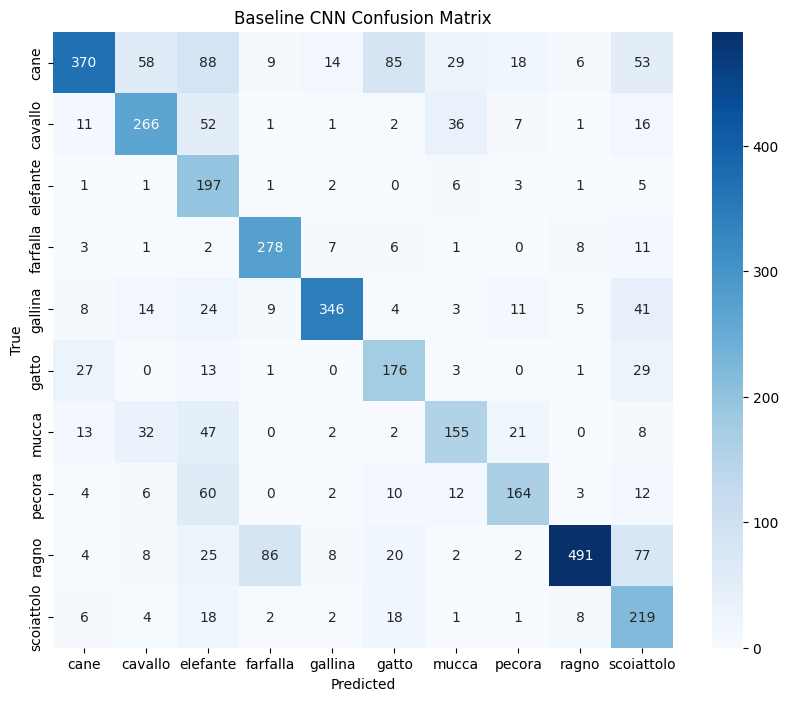

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import numpy as np

# Load best weights (optional, usually EarlyStopping restores them automatically)
# model.load_weights('baseline_best.keras')

print("Running predictions...")
logits = model.predict(test_ds)
preds = np.argmax(logits, axis=1)

print("\n--- BASELINE CLASSIFICATION REPORT ---")
print(classification_report(y_test, preds, target_names=class_names))

weighted_f1 = f1_score(y_test, preds, average='weighted')
print(f"Weighted F1-Score: {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Baseline CNN Confusion Matrix')
plt.show()